In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
import igraph as ig
import numpy as np

# ============================================================
# Repeat relevant operations
# ============================================================

# Build the small graph used to explain concepts
eoh = 4
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                          min_units=1, max_units=10, eoh=eoh, seed=42)
tug = util.build_time_unfolded_graph(g, eoh=eoh)
node_counts, arc_counts = util.get_counts(tug, flows, paths)
# Enumerate all paths
tugs, tugs_source = util._add_source_to_tug(tug)
tug_paths = util.enumerate_paths(tugs, tugs_source, exclude_source=True)
# Solve a restricted master problem
path_pool = tug_paths[:10]
rflows0, rpaths0 = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                                  initial_paths=path_pool, verbose=0, solver='piqp')
nres0, ares0 = util._get_residuals(tug, rflows0, rpaths0, node_counts, arc_counts)

# Column Generation

Because we cannot spend all day pricing

## Column Generation

**We now have a mechanism to price all variables not in the pool**

...But we still need to handle an exponential number of them

* I.e. enumerating paths would still be prohibitively expensive

> **What can we do about it?**

* There is no need to find _all paths_ with negative $\frac{\partial}{\partial x_j} f(x) < 0$
* We just need to determine whether _one such path_ exists

**Hence, we can _build_ a variable with the _most negative_ $\frac{\partial}{\partial x_j} f(x) < 0$**

* Since variables correspond to columns in LP
* ...This approach is called _Column Generation_

## Pricing ad Optimization

**In practice, we view pricing as an _optimization problem_**

* In our case we are looking at paths
* ...So it make sense to visualize them on the Time Unfolded Graph

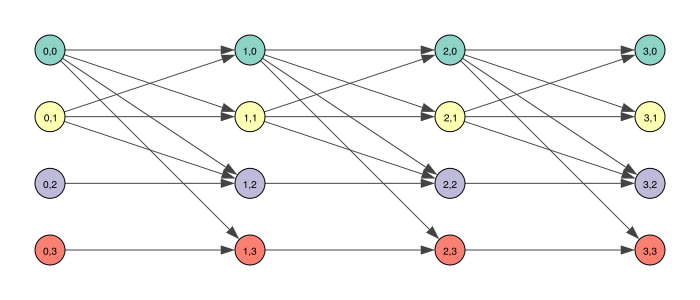

In [2]:
ig.plot(tug, **util.get_visual_style(tug), bbox=(700, 300), margin=50)

## Pricing ad Optimization

**When you want to consider all paths in a directed graph**

* ...It is convenient to add a fake source node
* Then you can assume that all paths start from that node

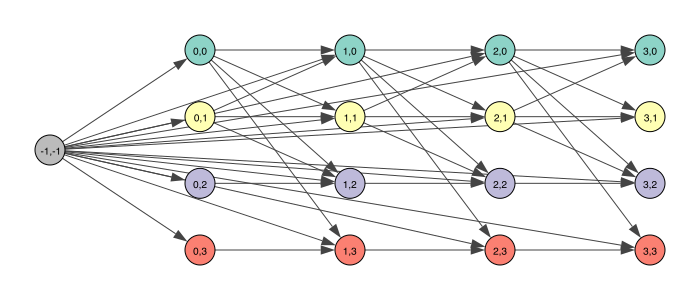

In [3]:
ig.plot(tugs, **util.get_visual_style(tugs), bbox=(700, 300), margin=50)

## Pricing as Optimization

**We can treat our residual as _node and arc weights_**

* In the plot, a grey shade corresponds to near-zero weight
* A blue shade is used for negative weights, and a red share for positive ones

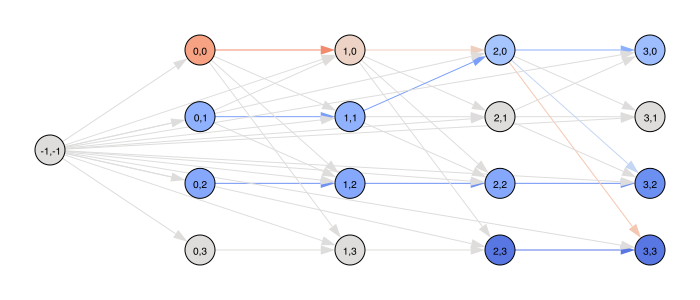

In [4]:
visual_style = util.get_visual_style(tugs, vertex_weights=nres0, edge_weights=ares0)
ig.plot(tugs, **visual_style, bbox=(700, 300), margin=50)

## Pricing as Optimization

**The our pricing problem corresponds to a shortest path problem**

* We care about the path with the most negative sum of residuals
* ...And therefore the smallest total weight

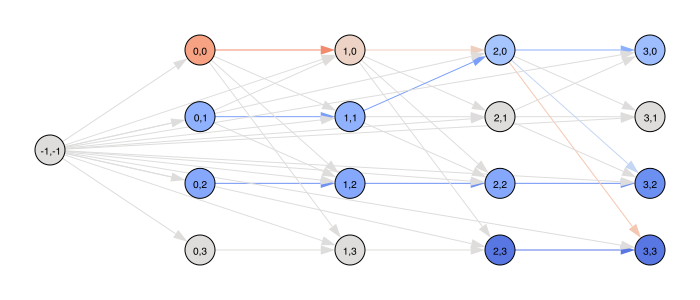

In [5]:
visual_style = util.get_visual_style(tugs, vertex_weights=nres0, edge_weights=ares0)
ig.plot(tugs, **visual_style, bbox=(700, 300), margin=50)

## Shortest Path Algorithms

**Optimization problems over graphs**

...Are often amenable to _dedicated, very efficient, algorithms_

> **What about our graph?**

**Weights can be negative**

* ...So one may think of using the [Bellman-Ford algorithm](https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm), which runs in $O(n_v n_e)$

**...But this is a Direct, _Acyclic_ Graph (DAG)**

* Meaning that we can process the nodes in _topological order_
* ...And apply [Dijkstra algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm), which runs in $O(n_e)$

## Dijkstra's Algorithm for DAGs

**Intuitively, we proceed as follows**

* $Q = [0]$ # We enqueue the fake source node
* $sp_i = [], \forall i = 0..n_v$ # All shortest paths are empy
* $\text{while $|Q| > 0$:}$
  - $\text{pop a node $i$ from $Q$}$
  - $\text{append $i$ to $sp_i$}$ # Extend the shortest path
  - $\text{for $j$ successor of $i$:}$
    - $\text{mark the arc $(i, j)$ as visited}$
    - $\text{if the shortest path passing for $i$ is shorter than $sp_j$}$
      - $\text{update $sp_j$}$ # Keep only the shortest path to $j$
    - $\text{if all ingoing arcs for $j$ have been visited}$
      - $\text{append $j$ in $Q$}$

## Pricing via Shortest Paths

**The approach is implemented in the `solve_pricing_problem` function**

...Which returns shortest paths _to all TUG nodes_

In [6]:
ncosts_a, npaths_a = util.solve_pricing_problem(tug, rflows0, rpaths0,
                                             node_counts, arc_counts, filter_paths=False)
print('COST: PATH')
util.print_solution(tug, ncosts_a, npaths_a, sort=None)

COST: PATH
-39.66: 0,2 > 1,2 > 2,2 > 3,2
-31.37: 0,1 > 1,1 > 2,0 > 3,3
-31.37: 0,1 > 1,1 > 2,0 > 3,0
-27.36: 0,2 > 1,2 > 2,2
-23.18: 0,1 > 1,1 > 2,0
-23.18: 0,1 > 1,1 > 2,0 > 3,1
-16.42: 0,2 > 1,2
-14.68: 0,1 > 1,1
-14.68: 0,1 > 1,1 > 2,1
-11.77: 0,1 > 1,0 > 2,3
-5.47: 0,2
-4.89: 0,1
-3.60: 0,1 > 1,0
0.00: 0,3
0.00: 1,3
4.61: 0,0


## Pricing via Shortest Paths

**We can ask for paths with a negative weighs/gradient term**

In [7]:
ncosts, npaths = util.solve_pricing_problem(tug, rflows0, rpaths0,
                                             node_counts, arc_counts, filter_paths=True)
print('COST: PATH')
util.print_solution(tug, ncosts, npaths, sort=None)

COST: PATH
-39.66: 0,2 > 1,2 > 2,2 > 3,2
-31.37: 0,1 > 1,1 > 2,0 > 3,3
-31.37: 0,1 > 1,1 > 2,0 > 3,0
-27.36: 0,2 > 1,2 > 2,2
-23.18: 0,1 > 1,1 > 2,0
-23.18: 0,1 > 1,1 > 2,0 > 3,1
-16.42: 0,2 > 1,2
-14.68: 0,1 > 1,1
-14.68: 0,1 > 1,1 > 2,1
-11.77: 0,1 > 1,0 > 2,3
-5.47: 0,2
-4.89: 0,1
-3.60: 0,1 > 1,0


* Returning multiple paths is usually a good idea
* ...Since it typically speeds up the convergence of our dynamic method

# Let's Loop!

Time to start iterating

## Does it Work?

**Every complex endeavor is worth a double (or triple) check**

Let's check again our baseline result:

In [8]:
rflows0, rpaths0 = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                                  initial_paths=path_pool, verbose=0, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows0, rpaths0, sort='descending')
sse = util.get_reconstruction_error(tug, rflows0, rpaths0, node_counts, arc_counts)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
1.96: 0,0 > 1,0 > 2,0 > 3,2
1.86: 0,0 > 1,0 > 2,0 > 3,3
0.79: 0,0 > 1,0 > 2,0 > 3,0
RSSE: 25.58


## Does it Work?

**Every complex endeavor is worth a double (or triple) check**

Let's try adding paths with _non-negative_ gradient terms

In [9]:
p_paths = [p for p, c in zip(npaths_a, ncosts_a) if c >= 0]
path_pool1_p = path_pool + p_paths

rflows1_p, rpaths1_p = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                                  initial_paths=path_pool1_p, verbose=0, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows1_p, rpaths1_p, sort='descending')
sse = util.get_reconstruction_error(tug, rflows1_p, rpaths1_p, node_counts, arc_counts)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
1.96: 0,0 > 1,0 > 2,0 > 3,2
1.86: 0,0 > 1,0 > 2,0 > 3,3
0.79: 0,0 > 1,0 > 2,0 > 3,0
RSSE: 25.58


* This is perfectly useless
* ...Just as expected!

## Does it Work?

**Every complex endeavor is worth a double (or triple) check**

Now, let's try again with paths having _negative_ gradient terms

In [10]:
n_paths = [p for p, c in zip(npaths_a, ncosts_a) if c < 0]
path_pool1 = path_pool + n_paths
rflows1, rpaths1 = util.solve_path_selection_full(tug, node_counts, arc_counts,
                                                  initial_paths=path_pool1, verbose=0, solver='piqp')
print('FLOW: PATH')
util.print_solution(tug, rflows1, rpaths1, sort='descending')
sse = util.get_reconstruction_error(tug, rflows1, rpaths1, node_counts, arc_counts)
print(f'RSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
5.79: 0,2 > 1,2 > 2,2 > 3,2
3.27: 0,1 > 1,1 > 2,0 > 3,3
2.30: 0,1 > 1,1 > 2,0 > 3,0
1.70: 0,1 > 1,0 > 2,3
1.13: 0,0 > 1,0 > 2,0 > 3,2
0.65: 0,0 > 1,0 > 2,0 > 3,3
0.56: 0,0 > 1,0 > 2,0 > 3,0
RSSE: 15.18


This time we have a better solution!

## The Column Generation Code

**Our CG code can be found in the `trajectory_extraction_cg` function**

First, we define our initial path pool

```python
paths = [[v.index] for v in tug.vs]
```

* We use one path per node, consisting of the node itself

Then we start looping:

```python
for it in range(max_iter):
    # Solve the master problem
    ...
    # Solve the pricing problem
    ...
```

* We control the total run-time via an iteration limit

## The Column Generation Code

**Our CG code can be found in the `trajectory_extraction_cg` function**

When we add the new paths, we take care of discarding duplicates

```python
old_as_set = set([tuple(p) for p in paths])
found_as_set = set([tuple(p) for p in np])
new_as_set = old_as_set.union(found_as_set)
```

* Duplicates should not theoretically arise
* ...But they may in practice due to numerical errors
* ...Or when we use approximate solvers

We trigger an eary stop if no new path can be added:

```python
if nnew == 0: break
```

## Column Generation in Action

**Let's test CG on that graph that took ~5 sec with the baseline**

In [11]:
g8_5, t8_5, f8_5, p8_5, nc8_5, ac8_5 = util.get_default_benchmark_graph(nnodes=8, eoh=5, seed=42)
%time f8_5, p8_5 = util.trajectory_extraction_cg(t8_5, nc8_5, ac8_5, max_iter=30, verbose=1, solver='piqp')

It.0, sse: 310.26, #paths: 45, new: 5
It.1, sse: 91.33, #paths: 46, new: 1
It.2, sse: 0.00, #paths: 46, new: 0
CPU times: user 11.9 ms, sys: 413 μs, total: 12.3 ms
Wall time: 12.1 ms


**What if the graph is bigger?**

In [12]:
g20_7, t20_7, f20_7, p20_7, nc20_7, ac20_7 = util.get_default_benchmark_graph(nnodes=20, eoh=7, seed=42)
%time f20_7, p20_7 = util.trajectory_extraction_cg(t20_7, nc20_7, ac20_7, max_iter=30, verbose=1, solver='piqp')

It.0, sse: 160.78, #paths: 176, new: 36
It.1, sse: 11.04, #paths: 179, new: 3
It.2, sse: 7.59, #paths: 191, new: 12
It.3, sse: 0.00, #paths: 191, new: 0
CPU times: user 51 ms, sys: 902 μs, total: 51.9 ms
Wall time: 51.7 ms


## Column Generation in Action

**Let's scale up even more**

With this graph, the total number of paths is $O(40^{10})$

In [13]:
g40_10, t40_10, f40_10, p40_10, nc40_10, ac40_10 = util.get_default_benchmark_graph(nnodes=40, eoh=10, seed=42)
%time f40_10, p40_10 = util.trajectory_extraction_cg(t40_10, nc40_10, ac40_10, max_iter=30, verbose=1, solver='piqp')

It.0, sse: 947.53, #paths: 572, new: 172
It.1, sse: 450.66, #paths: 676, new: 104
It.2, sse: 135.13, #paths: 772, new: 96
It.3, sse: 64.31, #paths: 861, new: 89
It.4, sse: 0.00, #paths: 878, new: 17
It.5, sse: 0.00, #paths: 880, new: 2
It.6, sse: 0.00, #paths: 880, new: 0
CPU times: user 579 ms, sys: 5.75 ms, total: 584 ms
Wall time: 586 ms


* The adds a small fraction of the total paths
* Convergence is fast
* ...And we manage to prove optimality!

## Some Considerations

**Column Generation is not easy approach to setup**

...But when it works, it can provide many advantages

* The master can stay remarkably clean
* Complicated constraints can be moved in the variable definitions
* ...And tackled in the pricing problem
* Scalability is pretty good, given the humongous search space

CG makes you _want_ to write models with massive number of variables

**Some caveats**

* A heuristic may still be faster (no sound mathematical theory, though...)
* It works well when you _can_ put all its advantages to use
* ...In particular, the master problem structure _should_ be very clean